In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow import keras
import jieba
import os
import numpy as np
import re
import collections

print(tf.__version__)

2.0.0


In [4]:
pos_path = '../../data/pos/'
neg_path = '../../data/neg/'
pos_list = os.listdir(pos_path)
neg_list = os.listdir(neg_path)

In [5]:
print(pos_list[0]),print(neg_list[0])

waimai_pos_1
waimai_neg_1


(None, None)

In [6]:
# 停用词词典
stop_words = []
# 读取停用词函数
with open("../../data/stop_words_line.txt", encoding="utf-8") as st:
    stop_words = st.readline().split(" ")

def delete_stop_words(words):
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def str_strim(line):
    new_line = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", line)
    return new_line.strip().strip().replace(" ", "").replace("\r", "").replace("\n", "")

def segment(line):
    return delete_stop_words(jieba.cut(str_strim(line)))

def read_data():
    # 所有词
    data = []
    # 训练样本
    train_data = []
    label = []
    for doc in pos_list:
        with open(pos_path + doc, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            for line in lines:
                words = segment(line)
                vector = []
                for word in words:
                    vector.append(word)
                    data.append(word)
                train_data.append(vector)
                label.append(1)
    for doc in neg_list:
        with open(neg_path + doc, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            for line in lines:
                words = segment(line)
                vector = []
                for word in words:
                    vector.append(word)
                    data.append(word)
                train_data.append(vector)
                label.append(0)
    return data,train_data, label

In [7]:
data, train_data_origin, train_label = read_data()
data_size = len(data)
len(data)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.496 seconds.
Prefix dict has been built succesfully.


89854

In [8]:
count = [['哦', -1]]
count.extend(collections.Counter(data).most_common(data_size - 1))

In [9]:
count[1],count[0],count[0][1]

(('味道', 1583), ['哦', -1], -1)

In [10]:
dictionary = {}
for word, _ in count:
    dictionary[word] = len(dictionary)

In [11]:
train_data_num = []
default_count = 0
for word in data:
    index = dictionary.get(word, 0)
    # 默认
    if index == 0:  
        default_count += 1
    train_data_num.append(index)
count[0][1] = default_count
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

In [12]:
train_data_num = []
default_count = 0
for words in train_data_origin:
    vector = []
    for word in words:
        index = dictionary.get(word, 0)
        # 默认
        if index == 0:  
            default_count += 1
        vector.append(index)
    train_data_num.append(vector)
count[0][1] = default_count
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

In [13]:
train_data_num[0], count[0], dictionary.get('哦')

([21, 2, 1, 4271], ['哦', 0], 0)

In [14]:
count[:5]

[['哦', 0], ('味道', 1583), ('好吃', 1563), ('吃', 1542), ('送餐', 1541)]

In [15]:
train_data_num[:5]

[[21, 2, 1, 4271],
 [3066, 3066, 3066],
 [27],
 [2478, 1, 975, 2155, 316],
 [15, 1, 228, 4]]

In [16]:
[reverse_dictionary[i] for i in train_data_num[0]]

['很快', '好吃', '味道', '足量']

In [17]:
type(train_data_num),type(train_data_num[0]),type(train_data_num[0][0])

(list, list, int)

In [18]:
# train_data = keras.preprocessing.sequence.pad_sequences([[1,2],[4,6,7,8]],padding='post',maxlen=1024)
train_data = keras.preprocessing.sequence.pad_sequences(train_data_num,padding='post',maxlen=256)

In [19]:
print(train_data[1])

[3066 3066 3066    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [20]:
# 层按顺序堆叠以构建分类器：
# 第一层是嵌入（Embedding）层。该层采用整数编码的词汇表，并查找每个词索引的嵌入向量（embedding vector）。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：(batch, sequence, embedding)。
# 接下来，GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。
# 该定长输出向量通过一个有 16 个隐层单元的全连接（Dense）层传输。
# 最后一层与单个输出结点密集连接。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。
# 输入形状是用于电影评论的词汇数目（10,000 词）

model = keras.Sequential()
model.add(keras.layers.Embedding(len(data), 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          1437664   
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,437,953
Trainable params: 1,437,953
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 一个模型需要损失函数和优化器来进行训练。由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），
# 我们将使用 binary_crossentropy 损失函数。这不是损失函数的唯一选择，例如，您可以选择 mean_squared_error 。
# 但是，一般来说 binary_crossentropy 更适合处理概率——它能够度量概率分布之间的“距离”，或者在我们的示例中，
# 指的是度量 ground-truth 分布与预测值之间的“距离”。

# 现在，配置模型来使用优化器和损失函数：
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
# train_data = train_data.astype(np.int64)
train_label = np.array(train_label)

In [24]:
len(train_data),len(train_label)

(11987, 11987)

In [25]:
# 创建一个验证集
train_size = 10000
x_val = train_data[train_size:]
y_val = train_label[train_size:]

partial_x_train = train_data[:train_size]
partial_y_train = train_label[:train_size]

In [26]:
type(partial_x_train), type(partial_x_train[0]), type(partial_x_train[0][0]),type(partial_y_train),type(partial_y_train[0])

(numpy.ndarray, numpy.ndarray, numpy.int32, numpy.ndarray, numpy.int64)

In [27]:
len(partial_x_train),len(partial_y_train),len(x_val),len(y_val)

(10000, 10000, 1987, 1987)

In [28]:
# 训练模型¶
# 以 512 个样本的 mini-batch 大小迭代 40 个 epoch 来训练模型。这是指对 x_train 和 y_train 张量中所有样本的的 40 次迭代。
# 在训练过程中，监测来自验证集的 10,000 个样本上的损失值（loss）和准确率（accuracy）：
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 10000 samples, validate on 1987 samples
Epoch 1/100
10000/10000 [==============================] - 2s 213us/sample - loss: 0.6868 - accuracy: 0.6000 - val_loss: 0.6285 - val_accuracy: 1.0000
Epoch 2/100
10000/10000 [==============================] - 1s 66us/sample - loss: 0.6792 - accuracy: 0.6000 - val_loss: 0.5746 - val_accuracy: 1.0000
Epoch 3/100
10000/10000 [==============================] - 1s 70us/sample - loss: 0.6744 - accuracy: 0.6000 - val_loss: 0.5286 - val_accuracy: 1.0000
Epoch 4/100
10000/10000 [==============================] - 1s 73us/sample - loss: 0.6729 - accuracy: 0.6000 - val_loss: 0.5105 - val_accuracy: 1.0000
Epoch 5/100
10000/10000 [==============================] - 1s 74us/sample - loss: 0.6726 - accuracy: 0.6000 - val_loss: 0.5125 - val_accuracy: 1.0000
Epoch 6/100
10000/10000 [==============================] - 1s 72us/sample - loss: 0.6721 - accuracy: 0.6000 - val_loss: 0.5043 - val_accuracy: 1.0000
Epoch 7/100
10000/10000 [=========================

Epoch 55/100
10000/10000 [==============================] - 1s 78us/sample - loss: 0.2891 - accuracy: 0.8941 - val_loss: 0.2582 - val_accuracy: 0.9079
Epoch 56/100
10000/10000 [==============================] - 1s 94us/sample - loss: 0.2870 - accuracy: 0.8941 - val_loss: 0.3235 - val_accuracy: 0.8641
Epoch 57/100
10000/10000 [==============================] - 1s 84us/sample - loss: 0.2843 - accuracy: 0.8943 - val_loss: 0.2598 - val_accuracy: 0.9064
Epoch 58/100
10000/10000 [==============================] - 1s 76us/sample - loss: 0.2803 - accuracy: 0.8954 - val_loss: 0.3266 - val_accuracy: 0.8616
Epoch 59/100
10000/10000 [==============================] - 1s 80us/sample - loss: 0.2788 - accuracy: 0.8967 - val_loss: 0.2654 - val_accuracy: 0.9034
Epoch 60/100
10000/10000 [==============================] - 1s 90us/sample - loss: 0.2765 - accuracy: 0.8981 - val_loss: 0.3038 - val_accuracy: 0.8752
Epoch 61/100
10000/10000 [==============================] - 1s 87us/sample - loss: 0.2737 - ac

In [29]:
# ===========================word2vec======================
# e = model.layers[0]
# weights = e.get_weights()[0]
# print(weights.shape) # shape: (vocab_size, embedding_dim)

# print_i = 0

# for word,num in words_dict.items():
#     print_i += print_i
#     if print_i > 10:
#         break
#     vec = weights[num+1] # skip 0, it's padding.
#     print(word + ':' + ' '.join([str(x) for x in vec]))

In [30]:
# 评估模型
# 模型性能 将返回两个值。损失值（loss）（一个表示误差的数字，值越低越好）与准确率（accuracy）。
results = model.evaluate(train_data,  train_label, verbose=2)
print(results)

11987/1 - 1s - loss: 0.5255 - accuracy: 0.9193
[0.21596541645986936, 0.9193293]


In [31]:
# model.fit() 返回一个 History 对象，该对象包含一个字典，其中包含训练阶段所发生的一切事件
# 有四个条目：在训练和验证期间，每个条目对应一个监控指标。我们可以使用这些条目来绘制训练与验证过程的损失值（loss）和准确率（accuracy），以便进行比较。
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
# 创建一个准确率（accuracy）和损失值（loss）随时间变化的图表
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

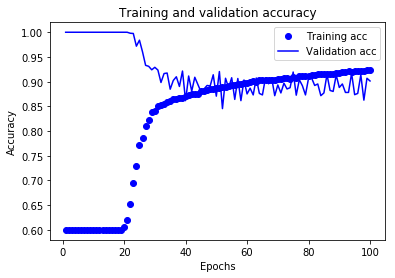

In [33]:
# 在该图中，点代表训练损失值（loss）与准确率（accuracy），实线代表验证损失值（loss）与准确率（accuracy）。

# 注意训练损失值随每一个 epoch 下降而训练准确率（accuracy）随每一个 epoch 上升。这在使用梯度下降优化时是可预期的——理应在每次迭代中最小化期望值。

# 验证过程的损失值（loss）与准确率（accuracy）的情况却并非如此——它们似乎在 20 个 epoch 后达到峰值。这是过拟合的一个实例：模型在训练数据上的表现比在以前从未见过的数据上的表现要更好。在此之后，模型过度优化并学习特定于训练数据的表示，而不能够泛化到测试数据。

# 对于这种特殊情况，我们可以通过在 20 个左右的 epoch 后停止训练来避免过拟合。稍后，您将看到如何通过回调自动执行此操作。
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()